# Wildfire Smoke Controls on Gross Primary Production in Central Canada

## Part 1: Data Scrubbing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# show full dataframes
pd.set_option('max_columns', None)

# for temporarily displaying function output
from IPython.display import clear_output

%run ./drf_stats.ipynb

In [2]:
# get data
data_in = pd.read_csv("drf_timeseries.csv", parse_dates=True, index_col=1).drop("Unnamed: 0", axis=1)

### Select only the relevant months

This study is really only concerned with what goes on between May and September, as the vast majority of primary production (trees photosynthesizing/consuming CO2) and wildfire activity happen in the summer

In [3]:
# select just the growing/wildfire season (may-sept, inclusive)
growing_season = pd.DataFrame()
for month in [5,6,7,8,9]:
    growing_season = growing_season.append(data_in[data_in.index.month == month])

# make sure the data stays in order by date
growing_season = growing_season.sort_values(by="datetime")
growing_season

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),AOD_681nm,AOD_709nm,Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,SH,LE,SLE,G,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,SW_DIF,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,RECO_PI,APAR,PPFD_DIF,FAPAR,ZL
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-08-05 00:00:00,0.0,NaN,0.043281,0.050140,NaN,NaN,0.056433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077186,NaN,NaN,0.084066,NaN,NaN,0.095379,0.109326,0.503352,NaN,NaN,377.728603,0.155769,NaN,16.754,238.260,2.5785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5670,10.3795,0.0,61.7660,94.6780,NaN,NaN,0.7295,NaN,NaN,-38.485,0.000,0.06,NaN,0.000,0.105,335.240,373.680,NaN,NaN,NaN,1.6125,NaN,NaN
2005-08-05 01:00:00,0.0,NaN,0.041713,0.049306,NaN,NaN,0.055380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077047,NaN,NaN,0.083923,NaN,NaN,0.094999,0.110109,0.510514,NaN,NaN,377.707512,0.155787,NaN,16.437,238.760,1.8935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.2685,10.1695,0.0,60.0260,94.6620,NaN,NaN,0.7475,NaN,NaN,-35.440,-0.005,0.19,NaN,0.000,-0.005,334.600,370.220,NaN,NaN,NaN,1.5790,NaN,NaN
2005-08-05 02:00:00,0.0,NaN,0.037905,0.045268,NaN,NaN,0.050330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070703,NaN,NaN,0.075927,NaN,NaN,0.086224,0.100517,0.493424,NaN,NaN,377.680050,0.155811,NaN,16.347,248.315,2.3990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9970,9.9720,0.0,59.3995,94.6285,NaN,NaN,0.7550,17.0,27.47,-30.630,0.000,0.35,NaN,0.000,-0.045,337.985,369.005,NaN,NaN,NaN,1.6050,NaN,NaN
2005-08-05 03:00:00,0.0,NaN,0.034070,0.040381,NaN,NaN,0.044884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063583,NaN,NaN,0.067235,NaN,NaN,0.077404,0.091669,0.470614,NaN,NaN,377.652588,0.155835,NaN,16.077,252.895,1.8860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7580,9.7935,0.0,60.1995,94.5740,NaN,NaN,0.7275,NaN,NaN,-45.005,0.000,0.00,NaN,0.000,-0.120,320.270,365.400,NaN,NaN,NaN,1.5550,NaN,NaN
2005-08-05 04:00:00,0.0,NaN,0.032243,0.038891,NaN,NaN,0.043012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060868,NaN,NaN,0.063953,NaN,NaN,0.075606,0.089504,0.507524,NaN,NaN,377.623732,0.155859,NaN,15.396,232.210,0.8960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5185,9.6225,0.0,60.8120,94.5105,NaN,NaN,0.6855,NaN,NaN,-46.400,0.160,-0.02,NaN,0.005,-0.290,314.705,361.375,NaN,NaN,NaN,1.8040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14 19:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 20:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 21:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find which measurements have the most complete data

In [4]:
check_complete(growing_season)

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_865nm:  0.0 %
AOD_779nm:  0.0 %
AOD_675nm:  6.44 %
AOD_667nm:  0.0 %
AOD_620nm:  0.0 %
AOD_560nm:  0.0 %
AOD_555nm:  0.0 %
AOD_551nm:  0.0 %
AOD_532nm:  0.0 %
AOD_531nm:  0.0 %
AOD_510nm:  0.0 %
AOD_500nm:  5.51 %
AOD_490nm:  0.0 %
AOD_443nm:  0.0 %
AOD_440nm:  6.32 %
AOD_412nm:  0.0 %
AOD_400nm:  0.0 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
AOD_681nm:  0.0 %
AOD_709nm:  0.0 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
SH:  0.0 %
LE:  34.41 %
SLE:  0.0 %
G:  0.0 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
SW_DIF:  0.0 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
RECO_PI:  4.32 %
AP

Pretty dismal. We need the AOD data, so set a cutoff at 5%. Hopefully we can interpolate the rest

In [5]:
data = keep_complete(growing_season, 5.0)
check_complete(data) # see if that worked

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_675nm:  6.44 %
AOD_500nm:  5.51 %
AOD_440nm:  6.32 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
LE:  34.41 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
PPFD_DIF:  34.87 %


### Interpolation

Now, go through each individual measurement and hand-tune the pandas interpolation scheme to come up with something realistic (If this can't be achieved, toss the whole column). There is a balance here, we are trying to maximize coverage where all columns are finite (not NaNs, so we can perform PCA on as big of dataset as possible), without dangerously extending data beyond what is physical.

#### AOD Data

Intuition from the physical characteristics of the problem tells us that smoke events operate on a scale of hours to weeks. We can maybe therefore safely interpolate out to several days before getting into trouble. This does mean that we should now be suspicious of any effects we discover with a timescale less than a few days.

In [6]:
# get all the AOD columns that survived the purge
aod_list = []
for key in data.keys():
    if "AOD" in key:
        aod_list.append(key)
        print(key)

AOD_1640nm
AOD_1020nm
AOD_870nm
AOD_675nm
AOD_500nm
AOD_440nm
AOD_380nm
AOD_340nm


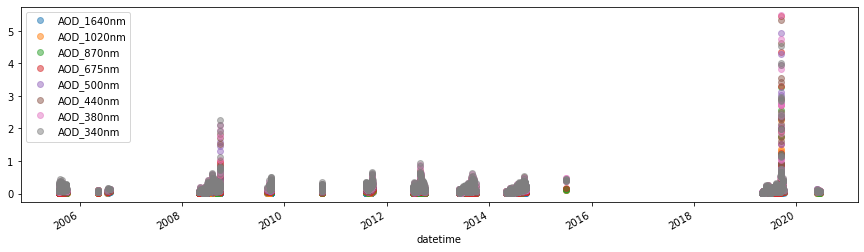

In [7]:
# peek at the raw AOD data. How big of gaps am I willing to try to fill?
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

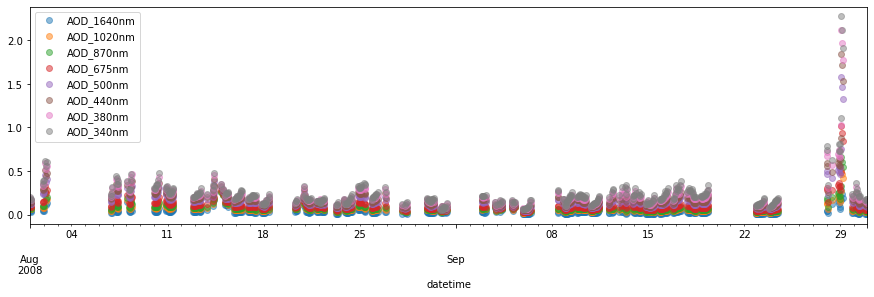

In [8]:
# enhance...
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

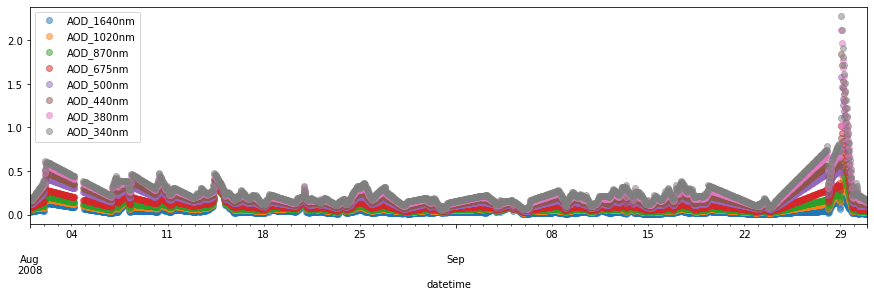

In [9]:
# interpolate with a limit of 48 hour gaps between real data points
data[aod_list] = data[aod_list].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

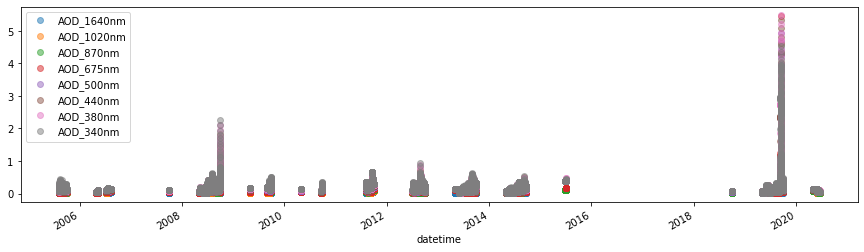

In [10]:
# zoom out again
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

In [11]:
# how much did that help?
check_complete(data[aod_list])

AOD_1640nm:  31.0 %
AOD_1020nm:  35.14 %
AOD_870nm:  36.0 %
AOD_675nm:  35.91 %
AOD_500nm:  31.1 %
AOD_440nm:  35.2 %
AOD_380nm:  36.0 %
AOD_340nm:  35.92 %


48 hours of interpolation will massively increase the amount of viable data (remember, we can't perform PCA on data where *any* of the elements are NaN) while maintaining some sort of realism. What we are implicitly saying here is that we can expect whatever smoke/pollutant/synoptic weather pattern to persist with a timescale of $\approx$ 48 hours (or at least we hope so).

#### Other AERONET Data

- `Precipitable_Water(cm)` total precipitable water in the column
- `Ozone(Dobson)`          calculated ozone concentration
- `NO2(Dobson)`            calculated nitrogen dioxide concentration

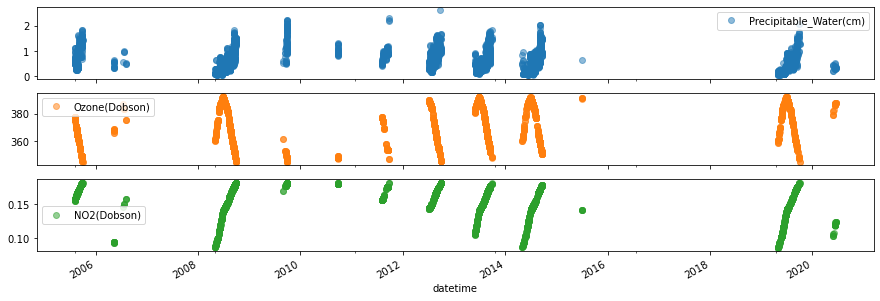

In [12]:
# handle these three much like AOD data above
aeronet = ["Precipitable_Water(cm)", "Ozone(Dobson)", "NO2(Dobson)"]

#fig, ax = plt.subplots(figsize=(15,4))
data[aeronet].plot(marker='o', linestyle="none", alpha=0.5, subplots=True, figsize=(15,5));

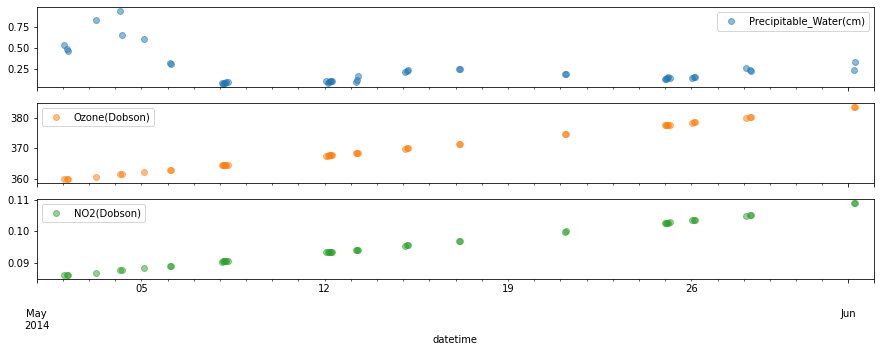

In [13]:
# zoom in on a period of interest (a dense-looking bit of the above plot)
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                              linestyle="none", 
                                              alpha=0.5,
                                              subplots=True, 
                                              figsize=(15,5));

Ozone episodes and precipitable water tend to be regional in scale (Mckendry 1993) and depend on both synoptic and boundary layer meteorology, as well as precursor concentrations (often supplied by wildfires). NO2 has an extremely long atmospheric lifetime (131 years - see Seinfeld and Pandis 2016), so we shall assume that the daily variation is small. Use the same 48 hr interpolation limit as with AOD. (Note: AERONET stations take data several times daily, I'm not sure why this data is so sparse..)

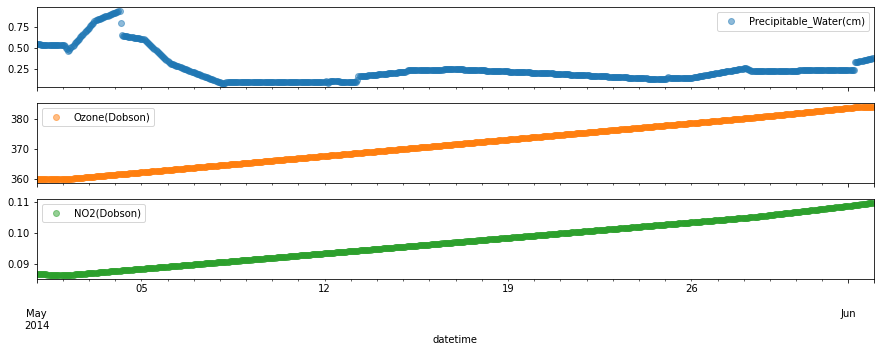

In [14]:
# interpolate with a limit of 48 hour gaps between real data points
data[aeronet] = data[aeronet].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                                linestyle="none", 
                                                alpha=0.5,
                                                subplots=True, 
                                                figsize=(15,5));

In [15]:
# check data completeness after interpolation
check_complete(data[aeronet])

Precipitable_Water(cm):  35.91 %
Ozone(Dobson):  36.0 %
NO2(Dobson):  36.0 %


### More Interpolated Variables 

(move on for now)

### Assemble the Final Dataset

In [16]:
# after we finish messing about with interpolations, drop all rows that still have missing data
data_complete = data.dropna()
data_complete

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,LE,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,PPFD_DIF
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-09-29 06:00:00,0.0,0.024802,0.039233,0.045199,0.053805,0.070111,0.078917,0.091111,0.096388,0.350353,364.987069,0.110711,0.3730,8.4910,350.570,3.1740,7.0590,5.5330,0.6650,-40.5000,1.4265,7.1695,7.2140,0.0,81.4295,93.0645,399.85,400.80,0.2070,19.37,32.801,-10.0150,0.390,1.145,-0.025,-0.005,342.230,353.395,9.5050,0.2590
2007-09-29 10:00:00,0.0,0.024792,0.039221,0.045186,0.053794,0.070100,0.078906,0.091097,0.096369,0.350300,364.983070,0.110692,0.9965,8.1105,342.435,6.3670,-5.7805,-5.2700,-0.5100,131.3000,27.4100,6.8630,6.9430,0.0,85.5990,93.2375,390.80,391.20,0.1560,19.16,32.530,197.2300,550.345,251.120,24.265,21.895,331.980,363.975,9.7890,466.1100
2007-09-29 18:00:00,0.0,0.024772,0.039197,0.045160,0.053772,0.070078,0.078885,0.091071,0.096330,0.350195,364.975072,0.110654,0.5070,4.3960,330.825,4.0575,1.3440,1.4360,-0.0915,-34.6300,10.7730,7.1165,7.1590,0.0,92.2775,93.8190,383.05,383.75,0.0655,20.36,32.970,-19.6750,34.955,23.330,2.105,3.805,300.820,340.020,8.1695,26.7740
2007-09-29 22:00:00,0.0,0.024762,0.039186,0.045147,0.053761,0.070067,0.078874,0.091057,0.096311,0.350142,364.971073,0.110635,0.2515,2.6745,318.795,3.0290,2.1190,1.0605,0.1870,-31.3050,-3.1390,6.7620,6.9025,0.0,91.6660,94.0490,386.85,387.75,0.0625,20.67,33.220,-73.9550,0.005,0.090,0.030,0.120,254.145,328.065,7.0650,0.1510
2007-09-30 10:00:00,0.0,0.024732,0.039150,0.045107,0.053727,0.070034,0.078842,0.091018,0.096253,0.349984,364.959077,0.110578,0.3270,4.2680,252.975,1.8390,-2.3960,-2.0400,-0.3555,50.6850,118.7650,5.3620,5.8430,0.0,76.8005,94.4990,379.65,380.45,0.1935,20.90,33.520,277.6200,811.575,410.330,42.610,37.535,244.440,339.620,6.4250,195.3350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-01 18:00:00,0.0,0.033652,0.032546,0.040330,0.052824,0.082452,0.098096,0.119279,0.129015,1.348858,347.481642,0.180454,0.9730,6.4765,47.350,7.0945,0.9255,0.7855,0.1405,-21.3125,22.1550,0.7795,0.1720,0.0,55.8875,93.0315,393.35,392.00,0.4270,27.33,32.980,-7.0250,42.785,17.050,0.970,0.750,329.830,352.800,5.6455,39.9280
2010-05-01 22:00:00,0.0,0.033621,0.032528,0.040309,0.052798,0.082413,0.098049,0.119220,0.128948,1.348251,347.483668,0.180453,0.8770,4.5510,44.975,5.9395,1.7530,1.7190,0.0340,-29.6150,16.1000,0.6585,0.1500,0.0,66.0370,93.3590,394.05,392.70,0.2880,27.41,33.070,-17.2950,0.000,0.140,0.010,-0.040,326.240,343.715,5.8395,0.1380
2010-05-02 02:00:00,0.0,0.033590,0.032509,0.040288,0.052772,0.082374,0.098002,0.119161,0.128881,1.347643,347.485694,0.180452,0.4810,2.4680,35.785,3.6775,1.0770,1.0440,0.0340,-36.6550,2.3575,0.4805,0.1145,0.0,72.1790,93.5485,394.40,393.55,0.2040,27.48,33.170,-64.7700,0.000,-0.455,-0.005,0.020,267.215,331.510,5.4915,0.1435


In [17]:
#######################################################
### choose which version of the dataset to use here ###
#######################################################

data = data_complete

## Part 2: Perform PCA On the Dataset

Now that we have a somewhat complete (at least a bit less gappy) dataset, we can turn back to the question at hand. How big of a role does wildfire smoke play in determining the CO2 fluxes near a forest canopy? 

The basic workflow is:

1) Group by smoke level to generate 4 dataframes

2) Split off outputs (carbon flux data) from the inputs and do PCA on the inputs

3) Look at the PCs of each regime and compare

In [18]:
# Split the dataset by smoke level, and perform the analysis individually for each
smoke_lvl = data.groupby("smoke")

# Store each group in a dictionary
smoke_dict = {}
for key, value in smoke_lvl:
    smoke_dict[key] = value

### Control Case: No Smoke

These next few cells are interactive. Run them, and a plot of each PC mode and it's associated fractional variance will appear. We want to pick enough modes to explain the vast majority of the variance within the data, but few enough as to not overcomplicate the analysis (the whole point of PCA is to *reduce* the number of dimensions).

(Im using 5 as my number of modes)

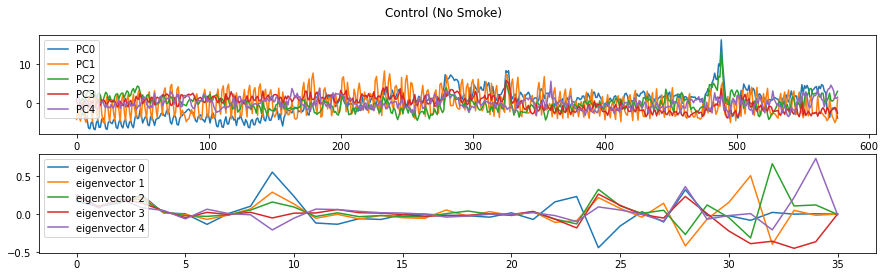

In [19]:
eigvecs0, PCs0, outputs0 = do_PCA(smoke_dict[0.0], "Control (No Smoke)")

#### Analysis

analysis goes here

### Case 2: Light Smoke

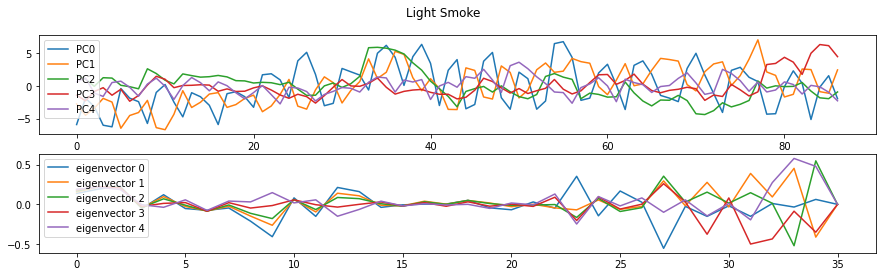

In [21]:
eigvecs1, PCs1, outputs1 = do_PCA(smoke_dict[5.0], "Light Smoke")

#### Analysis

analysis goes here

## Part 3: MLR with the PCs

Can we use the PCs to predict carbon uptake?

=== MLR Coefficients ===
PC0: 5.094066330010936
PC1: -9.541091387774902
PC2: -3.934529312396413
PC3: 2.501039433758259
PC4: 0.4744260078685788


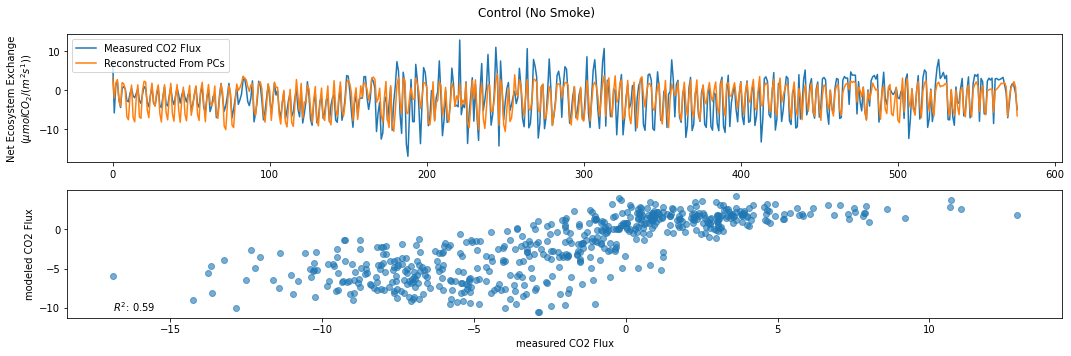

In [29]:
# do MLR on the non-smoke control case
do_MLR(PCs0, outputs0, "Control (No Smoke)", 5)

In [31]:
# Interpret the results: Rank each input variable by relative importance in the leading PC
rank_inputs(smoke_dict[0.0], eigvecs0, 5, rank_mode=1)

,eigvec 0,eigvec 1,eigvec 2,eigvec 3,eigvec 4
SW_OUT,0.081251,0.510360,0.314436,0.390351,0.008132
PPFD_IN,0.324224,0.421100,0.269258,0.234983,0.366271
LW_IN,0.023928,0.397561,0.669165,0.357917,0.207214
Ozone(Dobson),0.557844,0.291847,0.161619,0.049573,0.208336
AOD_1640nm,0.173050,0.227332,0.242592,0.255267,0.260474
AOD_675nm,0.255303,0.227258,0.197284,0.150372,0.086335
VPD_PI,0.443752,0.220108,0.328968,0.266417,0.096598
AOD_870nm,0.152346,0.174421,0.191831,0.203285,0.203504
PPFD_OUT,0.019952,0.156189,0.044701,0.222448,0.018150
NETRAD,0.103396,0.145351,0.051976,0.050517,0.092610


### Repeat for Light Smoke Case

=== MLR Coefficients ===
PC0: -5.499841128988115
PC1: 6.4344391970602866
PC2: -2.7483043647752394
PC3: -3.8915497676787627
PC4: -4.136829155056806


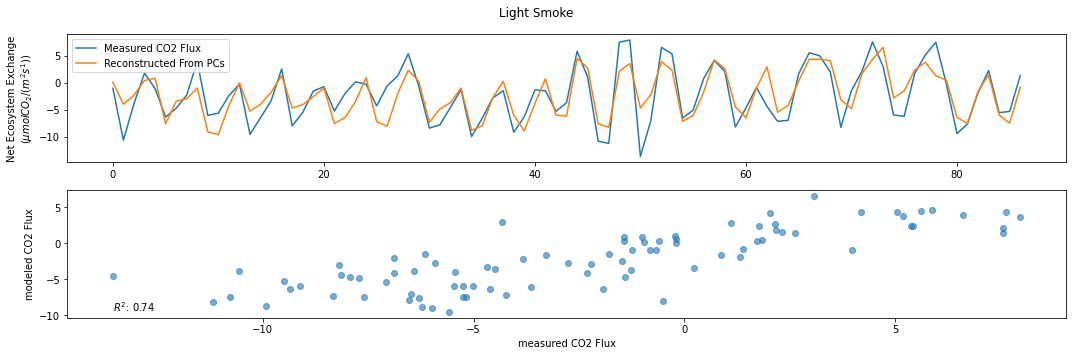

In [32]:
# do MLR on the light smoke case
do_MLR(PCs1, outputs1, "Light Smoke",5)

In [28]:
# Interpret the results: Rank each input variable by relative importance of the PC with the largest weight in MLR
rank_inputs(smoke_dict[5.0], eigvecs1, 5, rank_mode=1)

,eigvec 0,eigvec 1,eigvec 2,eigvec 3,eigvec 4
LW_OUT,0.033814,0.454662,0.522468,0.086264,0.579999
H2O,0.062427,0.413599,0.549835,0.351591,0.480208
SW_OUT,0.151278,0.390522,0.147258,0.501200,0.195448
NETRAD,0.555154,0.296224,0.356292,0.260727,0.099836
SW_IN,0.151695,0.278150,0.154496,0.377386,0.145931
Ozone(Dobson),0.408390,0.263985,0.179799,0.014950,0.148195
AOD_1020nm,0.193113,0.218678,0.222698,0.222556,0.216073
AOD_870nm,0.229294,0.214449,0.214443,0.208662,0.188483
AOD_1640nm,0.138065,0.156797,0.167049,0.182121,0.190549
Precipitable_Water(cm),0.212361,0.148046,0.113079,0.046634,0.031031


We seem to be doing a reasonable (okay, not great) job of predicting small variations in CO2 uptake as a linear function of our PCs, but seem to be missing the extreme events. This probably means CO2 is weakly non-linear -- the further away we get from our starting point (in this case the mean of the data), the less we should trust a linear approximation. 

If we keep all the modes (ie use all the data available, we can get $R^2$ up to 0.86 and 0.95 for control and low smoke respectively